In [118]:
import pandas as pd
import numpy as np
import ChartingFunctions.plot_strategy as plt_st
import matplotlib.pyplot as plt
import Labeling.getDailyVol as gdv
import Sampling.Sampling as spl
import Labeling.TBM as tbm
import Labeling.getLabel as gl
import Trading.strategy as strategy
import FractDiff.fractdiff as fdiff

In [119]:
class Indicator:

    def __init__(self, open, high, low, close):
        self.open = open
        self.high = high
        self.low = low
        self.close = close
    
    # Money flow multiplier
    def mfm(self):
        return ((self.close - self.low)- (self.high - self.close))/(self.high - self.low)


In [120]:
df = pd.read_parquet("IntradayData/BTCUSD_2020-04-07_2022-04-06.parquet")
df = df.set_index('DATE')
close = df['CLOSE']

In [173]:
close = df['CLOSE'][0:1000]

In [222]:
label = Labelling(close)
l1 = label.tbm(0.005, 0.005, 300)

In [223]:
df_ = pd.DataFrame(close)
df_['side'] = l1

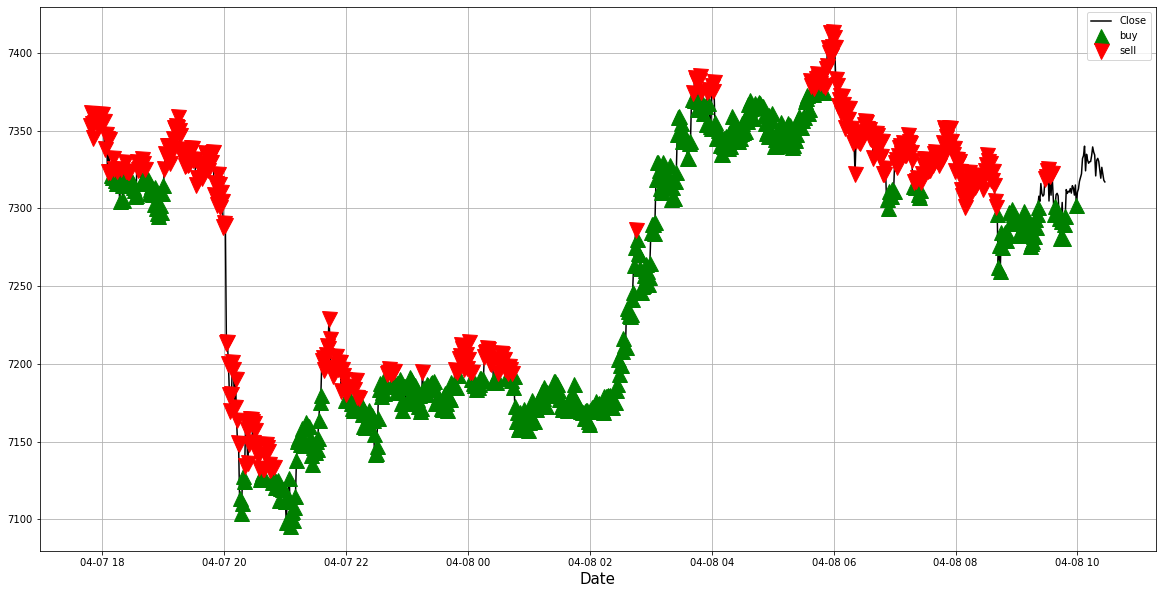

In [224]:
plt_st.plot_position(df_,0,4000)

In [209]:
class Labelling:

    def __init__(self, value):
        self.value = value

    # Min max
    def min_max(self, window, total):
        
        label = pd.Series(index=self.value.index,dtype='int8').fillna(0)

        win_start = 0
        win_end = win_start + window
        count_row = 0

        while count_row <= total:
        
            min_value = min(self.value[win_start:win_end])
            max_value = max(self.value[win_start:win_end])
            idx_min = self.value[win_start:win_end].idxmin()
            idx_max = self.value[win_start:win_end].idxmax()
            
            label.loc[idx_min] = 1
            label.loc[idx_max] = -1

            win_start = int((win_end + win_start)/2)
            win_end = win_start + window
            count_row = win_end

        return label

    # Triple barrier method
    def tbm(self, pt, sl, limit):

        label = pd.Series(index=self.value.index,dtype='int8').fillna(0)

        for i in range(len(self.value)):

            cum_return = self.value[i:i+limit].diff().fillna(0).cumsum()/self.value[i]
            index_touch = (((cum_return)>pt)|((cum_return)<-sl)).idxmax()

            if cum_return[index_touch]>0:
                label.iloc[i]=1

            elif cum_return[index_touch]<0:
                label.iloc[i]=-1
        
        return label

In [208]:
(((cum_return)>0.005)|((cum_return)<-0.004)).idxmax()

Timestamp('2020-04-07 18:08:00')

In [200]:
cum_return

DATE
2020-04-07 17:48:00    0.000000
2020-04-07 17:49:00    0.001208
2020-04-07 17:50:00    0.000194
2020-04-07 17:51:00   -0.001042
2020-04-07 17:52:00    0.000340
2020-04-07 17:53:00    0.001030
2020-04-07 17:54:00    0.000919
2020-04-07 17:55:00    0.000435
2020-04-07 17:56:00   -0.000090
2020-04-07 17:57:00    0.000978
2020-04-07 17:58:00    0.000998
2020-04-07 17:59:00    0.001096
2020-04-07 18:00:00    0.001096
2020-04-07 18:01:00    0.000468
2020-04-07 18:02:00   -0.001980
2020-04-07 18:03:00   -0.000635
2020-04-07 18:04:00   -0.001042
2020-04-07 18:05:00   -0.003967
2020-04-07 18:06:00   -0.001107
2020-04-07 18:07:00   -0.003943
2020-04-07 18:08:00   -0.004260
2020-04-07 18:09:00   -0.004456
2020-04-07 18:10:00   -0.002755
2020-04-07 18:11:00   -0.003713
2020-04-07 18:12:00   -0.004673
2020-04-07 18:13:00   -0.004918
2020-04-07 18:14:00   -0.003858
2020-04-07 18:15:00   -0.003763
2020-04-07 18:16:00   -0.004892
2020-04-07 18:17:00   -0.006532
Name: CLOSE, dtype: float64

In [5]:
index = Indicator(df['OPEN'],df['HIGHT'],df['LOW'],df['CLOSE'])

In [6]:
index.mfm()

DATE
2020-04-07 17:48:00   -0.095825
2020-04-07 17:49:00    0.315393
2020-04-07 17:50:00    0.305361
2020-04-07 17:51:00   -0.429549
2020-04-07 17:52:00    0.730403
                         ...   
2022-04-06 23:54:00   -0.356082
2022-04-06 23:55:00   -0.180951
2022-04-06 23:56:00   -1.000000
2022-04-06 23:57:00    0.265619
2022-04-06 23:58:00   -0.510865
Length: 1048690, dtype: float64

In [190]:
daily_std = gdv.getDailyVol(close)
trgt = daily_std.dropna()
label = gl.getLabel(close,1,trgt,0.01,0.05,[1,1])

In [191]:
df_close = df[['CLOSE']].merge(label.fillna(0),how='left',left_index=True,right_index=True)
df_close['side'] = 0
df_close.loc[df_close['return']<0,'side'] = -1
df_close.loc[df_close['return']>0,'side'] = 1

In [197]:
df_close[df_close['side']==1].side.sum()

208257

In [215]:
df_close_ = df_close_[['DAY','CLOSE','return','side']].groupby(['DAY']).last()

In [202]:
side_mov_avg,s1,s2 = strategy.cross_moving_average(df_close['CLOSE'],50,20)


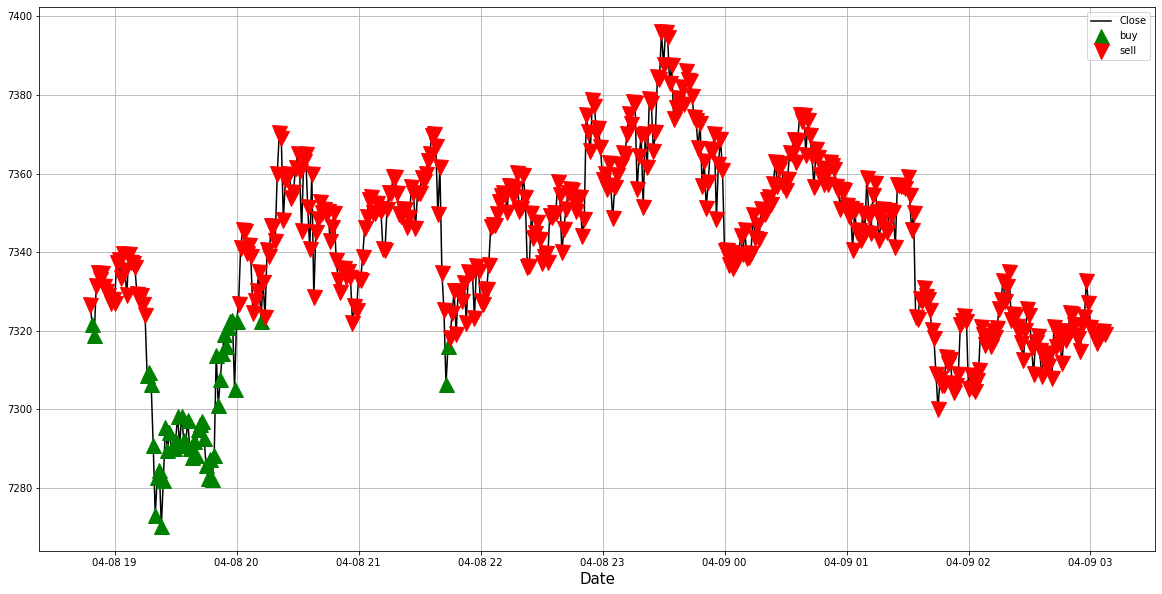

In [220]:
plt_st.plot_position(df_close,1500,2000)

In [ ]:


def plot_position(df,start,end,s1=None, s2=None):
    
    df = df[start:end]

    plt.figure(figsize = (20,10))
    plt.plot(df['CLOSE'],color='k',label='Close')

    # long position
    plt.plot(df[df['side'] == 1].index,df['CLOSE'][df['side'] == 1],
                '^', markersize = 15, color='g', label='buy')

    # short position
    plt.plot(df[df['side'] == -1].index,df['CLOSE'][df['side'] == -1],
                'v', markersize = 15, color='r', label='sell')
    
    if s1 is not None and s2 is not None:

        s1 = s1[start:end]
        s2 = s2[start:end]

        plt.plot(s1,color='b')
        plt.plot(s2,color='y')

                
    plt.xlabel('Date', fontsize = 15 )
    plt.legend()
    plt.grid()
    plt.show()
